In [1]:
##importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import cross_val_score 

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

#importing libraries used
import numpy as np
import pandas as pd
from pprint import pprint
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sn
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_auc_score,precision_recall_curve,recall_score,roc_curve,accuracy_score,precision_score,classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import math
from sklearn.preprocessing import LabelEncoder

from keras.utils.vis_utils import plot_model

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#importing dataset
activities=["climbingdown","climbingup","jumping","lying","running","sitting","standing","walking"]
location='/content/drive/MyDrive/Major_Project/clean_data.csv'
data=pd.read_csv(location)
data.drop(data.columns[[0]],axis=1,inplace=True)
(data.head())

,attr_time_gyro,attr_x_gyro,attr_y_gyro,attr_z_gyro,attr_time_acc,attr_x_acc,attr_y_acc,attr_z_acc,Activity,Label,Subject,Sample_Num
0,1435996982037,-0.815093,0.379639,0.408403,1435996982038,-0.217274,8.125920,1.502960,climbingdown,0,1,7
1,1435996982056,-0.977889,0.365895,0.438336,1435996982056,0.212485,8.208521,0.714071,climbingdown,0,1,7
2,1435996982076,-0.815704,0.554041,0.516832,1435996982077,0.249596,8.118139,-0.342969,climbingdown,0,1,7
3,1435996982095,-0.639164,0.823128,0.550735,1435996982095,0.270545,7.487866,0.112527,climbingdown,0,1,7
4,1435996982114,-0.506606,0.752267,0.589219,1435996982114,-0.014964,7.645285,0.856526,climbingdown,0,1,7


In [4]:
data.columns

Index(['attr_time_gyro', 'attr_x_gyro', 'attr_y_gyro', 'attr_z_gyro',
       'attr_time_acc', 'attr_x_acc', 'attr_y_acc', 'attr_z_acc', 'Activity',
       'Label', 'Subject', 'Sample_Num'],
      dtype='object')

In [5]:
def Range(a):
    return a.max()-a.min();

In [6]:
range_sample=data.groupby(['Activity','Subject','Sample_Num']).apply(Range).add_prefix('range_')
stdev_sample=data.groupby(['Activity','Subject','Sample_Num']).std().add_prefix('std_')
mean_sample=data.groupby(['Activity','Subject','Sample_Num']).mean().add_prefix('mean_')

In [7]:
mean_sample.head()

mean_attr_time_gyro  ...  mean_Label
Activity     Subject Sample_Num                       ...            
climbingdown 1       7                  1.435997e+12  ...         0.0
                     8                  1.435997e+12  ...         0.0
                     9                  1.435997e+12  ...         0.0
                     10                 1.435997e+12  ...         0.0
                     11                 1.435997e+12  ...         0.0

[5 rows x 9 columns]

In [8]:
total_data=pd.concat([stdev_sample,mean_sample,range_sample],axis=1)
total_data.reset_index(inplace=True)
total_data.head()

,Activity,Subject,Sample_Num,std_attr_time_gyro,std_attr_x_gyro,std_attr_y_gyro,std_attr_z_gyro,std_attr_time_acc,std_attr_x_acc,std_attr_y_acc,std_attr_z_acc,std_Label,mean_attr_time_gyro,mean_attr_x_gyro,mean_attr_y_gyro,mean_attr_z_gyro,mean_attr_time_acc,mean_attr_x_acc,mean_attr_y_acc,mean_attr_z_acc,mean_Label,range_attr_time_gyro,range_attr_x_gyro,range_attr_y_gyro,range_attr_z_gyro,range_attr_time_acc,range_attr_x_acc,range_attr_y_acc,range_attr_z_acc,range_Label
0,climbingdown,1,7,577.344583,0.786064,0.611101,0.402885,572.802628,1.028233,3.303459,1.968117,0.0,1.435997e+12,-0.233308,-0.028984,0.144039,1.435997e+12,0.533446,9.213110,2.375641,0.0,1978.0,3.587917,3.262326,1.893377,1977.0,5.589264,15.401898,11.406575,0.0
1,climbingdown,1,8,581.291714,0.942661,0.855090,0.374873,582.030385,1.470079,3.465349,2.752805,0.0,1.435997e+12,0.087604,-0.277429,0.141031,1.435997e+12,0.379439,9.024692,2.418964,0.0,1985.0,4.308738,5.279708,1.747991,1985.0,9.214684,15.316306,18.915391,0.0
2,climbingdown,1,9,579.635665,0.976116,0.803382,0.449999,579.373594,1.566840,3.024721,2.634441,0.0,1.435997e+12,-0.166086,-1.012663,-0.062882,1.435997e+12,0.155054,9.439451,1.640513,0.0,1981.0,4.679228,4.421137,2.178345,1982.0,7.890690,13.982736,21.457434,0.0
3,climbingdown,1,10,582.685275,0.995383,1.088734,0.458140,582.662663,2.012424,3.810429,2.944493,0.0,1.435997e+12,0.167801,-0.480547,0.051044,1.435997e+12,0.311127,8.968662,2.061090,0.0,2024.0,4.831944,7.441561,2.543032,2035.0,14.829087,15.386336,20.637421,0.0
4,climbingdown,1,11,580.331920,1.016299,1.113550,0.605436,581.116097,1.996506,3.389655,2.609269,0.0,1.435997e+12,-0.271014,-0.662130,-0.022941,1.435997e+12,0.001209,9.386025,1.909316,0.0,1959.0,4.633718,6.475477,2.649017,1969.0,11.089942,14.787786,16.913838,0.0


In [9]:
total_data.isnull().sum().sum()

0

In [10]:
total_data.columns

Index(['Activity', 'Subject', 'Sample_Num', 'std_attr_time_gyro',
       'std_attr_x_gyro', 'std_attr_y_gyro', 'std_attr_z_gyro',
       'std_attr_time_acc', 'std_attr_x_acc', 'std_attr_y_acc',
       'std_attr_z_acc', 'std_Label', 'mean_attr_time_gyro',
       'mean_attr_x_gyro', 'mean_attr_y_gyro', 'mean_attr_z_gyro',
       'mean_attr_time_acc', 'mean_attr_x_acc', 'mean_attr_y_acc',
       'mean_attr_z_acc', 'mean_Label', 'range_attr_time_gyro',
       'range_attr_x_gyro', 'range_attr_y_gyro', 'range_attr_z_gyro',
       'range_attr_time_acc', 'range_attr_x_acc', 'range_attr_y_acc',
       'range_attr_z_acc', 'range_Label'],
      dtype='object')

In [11]:
total_data.Activity.value_counts()

walking         1906
standing        1905
sitting         1882
lying           1853
running         1799
climbingup      1758
climbingdown    1427
jumping          279
Name: Activity, dtype: int64

In [12]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap='YlOrRd'):
    plt.rcParams.update({'font.size': 11})
    plt.figure(figsize=(25,10),)
    plt.imshow( cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();

In [13]:
def modify(y):
    Y=[]
    n=0
    for i in y:
        m=i.max()
        o=0
        for j in i:
            if j==m:
                Y.append(o)
                break
            else:
                o+=1
        n+=1
    return Y

In [14]:
def implement_model(model,title,bs,e):
    history=model.fit(x= X_train,
              y= Y_train,
              epochs=e,
              batch_size=bs,
              validation_data=(X_validate,Y_validate)
              )
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, e+1)
    plt.plot(epochs, loss, 'bo', label='Training_loss')
    plt.plot(epochs, val_loss, 'b', label='Validation_loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, 'bo', label='Training_accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validaion_accuracy')
    plt.legend()
    plt.show()

    result = model.evaluate(X_final, Y_final)
    print(result)
    # Y_predicted_train=model.predict(np.array(X_train))
    # Y_predicted_train=modify(Y_predicted_train)
    # Y_predicted_validate=model.predict(np.array(X_validate))
    # print(Y_predicted_validate)
    # Y_predicted_validate=modify(Y_predicted_validate)
    # print(Y_predicted_validate)
    # print(modify(Y_validate))
    # Y_predicted_final=model.predict(np.array(X_final))
    # Y_predicted_validate=modify(Y_predicted_validate)
    # Y_predicted_final=modify(Y_predicted_final)
    # # print(f'Training F1 score is: {f1_score(Y_train,Y_predicted_train,average="macro"):.3f}')
    # print(f'Validation F1 score is: {f1_score(Y_validate,Y_predicted_validate,average="macro"):.3f}')
    # print(f'Testing F1 score is: {f1_score(Y_final,Y_predicted_final,average="macro"):.3f}')
    # # print(f'Training Accuracy is: {accuracy_score(Y_train,Y_predicted_train):.3f}')
    # print(f'Validation Accuracy is: {accuracy_score(Y_validate,Y_predicted_validate):.3f}')
    # print(f'Testing Accuracy is: {accuracy_score(Y_final,Y_predicted_final):.3f}')
    # cm=confusion_matrix(Y_validate,Y_predicted_validate)
    # array=cm
    # df_cm = pd.DataFrame(array, index = [i for i in activities],
    #               columns = [i for i in activities])
    # plt.figure(figsize = (15,15))
    # plt.title("VALIDATION CONFUSION MATRIX")
    # sn.heatmap(df_cm, annot=True,fmt="d")
    # plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    # plt.tight_layout();
    # cm=confusion_matrix(Y_final,Y_predicted_final)
    # array=cm
    # df_cm = pd.DataFrame(array, index = [i for i in activities],
    #               columns = [i for i in activities])
    # plt.figure(figsize = (15,15))
    # plt.title("TEST CONFUSION MATRIX")
    # sn.heatmap(df_cm, annot=True,fmt="d")
    # plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    # plt.tight_layout();

In [15]:
def to_one_hot(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

In [16]:
columns=[
       'std_attr_x_gyro', 'std_attr_y_gyro', 'std_attr_z_gyro',
         'std_attr_x_acc', 'std_attr_y_acc', 'std_attr_z_acc', 
         'mean_attr_x_gyro', 'mean_attr_y_gyro', 'mean_attr_z_gyro', 
         'mean_attr_x_acc', 'mean_attr_y_acc', 'mean_attr_z_acc',
         'range_attr_x_gyro', 'range_attr_y_gyro','range_attr_z_gyro', 
         'range_attr_x_acc', 'range_attr_y_acc', 'range_attr_z_acc']

In [17]:
train_temp=total_data.Subject<=6
validate_temp=total_data.Subject==4
test_temp=total_data.Subject>=5
X_final=total_data[columns][test_temp]
y_final=total_data.Activity[test_temp]
X_train=total_data[columns][train_temp]
X_validate=total_data[columns][validate_temp]
y_train=total_data.Activity[train_temp]
y_validate=total_data.Activity[validate_temp]
le=LabelEncoder()
Y_train=le.fit_transform(y_train)
Y_validate=le.fit_transform(y_validate)
Y_final=le.fit_transform(y_final)

print('X_train->',Y_train.shape)
print('X_validate->',Y_validate.shape)
print(Y_validate)
Y_train = to_one_hot(Y_train,8)
Y_final = to_one_hot(Y_final,8)
Y_validate=to_one_hot(Y_validate,8)
print(Y_validate)
# Y_final=modify(Y_final)
# print(type(Y_final))
# # Y_train=modify(Y_train)
# Y_validate=modify(Y_validate)
# print(Y_final)

X_train-> (12809,)
X_validate-> (2211,)
[0 0 0 ... 7 7 7]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [18]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_validate=scaler.fit_transform(X_validate)
X_final = scaler.transform(X_final)
# print('Y_train->',Y_train.shape)
# print('Y_validate->',Y_validate.shape)
# print(Y_train.max(),Y_train.min())
# print('X_final->',X_final.shape)

In [19]:
input_dim = X_train.shape[1]
#initialising ANN
model = Sequential()
model.add(Dense(48, input_shape=(input_dim,), activation='relu',name="input"))
model.add(Dense(58, activation='relu',name="second"))
model.add(Dense(48, activation='relu',name="third"))
model.add(Dense(38, activation='relu',name="fourth"))
model.add(Dense(28, activation='relu',name="fifth"))
model.add(Dense(28, activation='relu',name="sixth"))
model.add(Dense(18, activation='relu',name="seventh"))
model.add(Dense(18, activation='relu',name="eigth"))
model.add(Dense(8,  activation='sigmoid',name="output"))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 48)                912       
_________________________________________________________________
second (Dense)               (None, 58)                2842      
_________________________________________________________________
third (Dense)                (None, 48)                2832      
_________________________________________________________________
fourth (Dense)               (None, 38)                1862      
_________________________________________________________________
fifth (Dense)                (None, 28)                1092      
_________________________________________________________________
sixth (Dense)                (None, 28)                812       
_________________________________________________________________
seventh (Dense)              (None, 18)                5

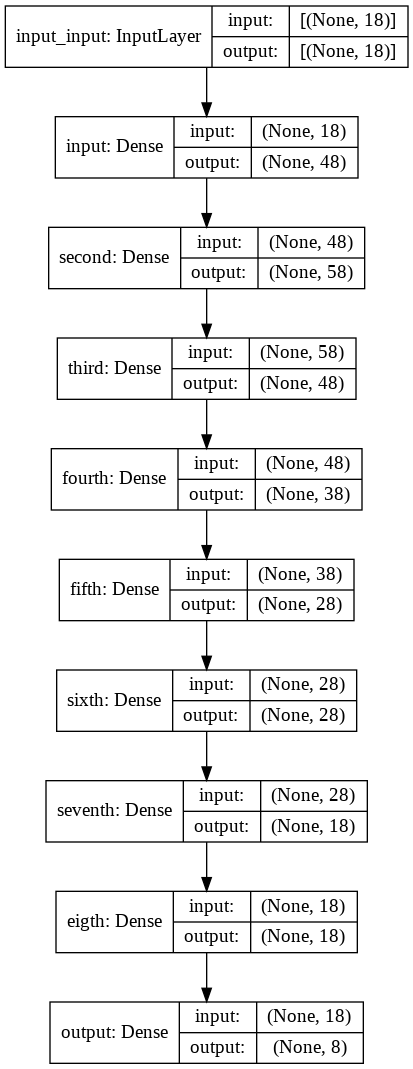

In [20]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [21]:
#Compiling

import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
from sklearn.utils import shuffle
epochs=200
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/200
92/92 [==============================] - 1s 8ms/step - loss: 2.0447 - accuracy: 0.1386 - val_loss: 1.9671 - val_accuracy: 0.1361
Epoch 2/200
92/92 [==============================] - 0s 2ms/step - loss: 1.9149 - accuracy: 0.1748 - val_loss: 1.8808 - val_accuracy: 0.3175
Epoch 3/200
92/92 [==============================] - 0s 3ms/step - loss: 1.8248 - accuracy: 0.3276 - val_loss: 1.8071 - val_accuracy: 0.2614
Epoch 4/200
92/92 [==============================] - 0s 3ms/step - loss: 1.7375 - accuracy: 0.3719 - val_loss: 1.6931 - val_accuracy: 0.3686
Epoch 5/200
92/92 [==============================] - 0s 2ms/step - loss: 1.5840 - accuracy: 0.4212 - val_loss: 1.4705 - val_accuracy: 0.3374
Epoch 6/200
92/92 [==============================] - 0s 2ms/step - loss: 1.3673 - accuracy: 0.4488 - val_loss: 1.2753 - val_accuracy: 0.3740
Epoch 7/200
92/92 [==============================] - 0s 2ms/step - loss: 1.1715 - accuracy: 0.5080 - val_loss: 1.1138 - val_accuracy: 0.6658
Epoch 8/200
9

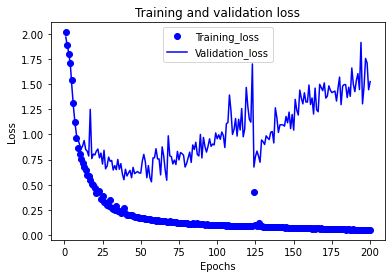

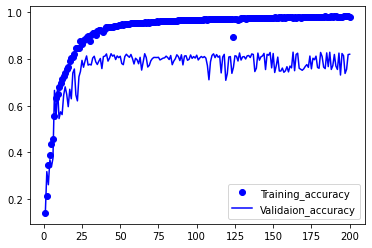

132/132 [==============================] - 0s 1ms/step - loss: 0.8051 - accuracy: 0.8205
[0.8050518035888672, 0.8205128312110901]


In [22]:
implement_model(model,'ANN',140,epochs)